In [1]:
!nvidia-smi

Sat Dec  9 22:06:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#Import Dataset
**German Traffic Sign Recognition Benchmark**
More than 40 classes
More than 50,000 images in total

In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip



--2023-12-09 22:06:12--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.8MB/s    in 13s     

2023-12-09 22:06:27 (20.3 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [4]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [5]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

In [6]:
#nb classes
len(train_folders)

43

#Analyse


In [7]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    #redim_carre
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [8]:
def show_sign_grid(image_paths):
  images=[]
  for path in image_paths:
    images.append(load_image(path))

  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(16, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

<ipython-input-8-5d0020776135>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  images = torch.as_tensor(images)


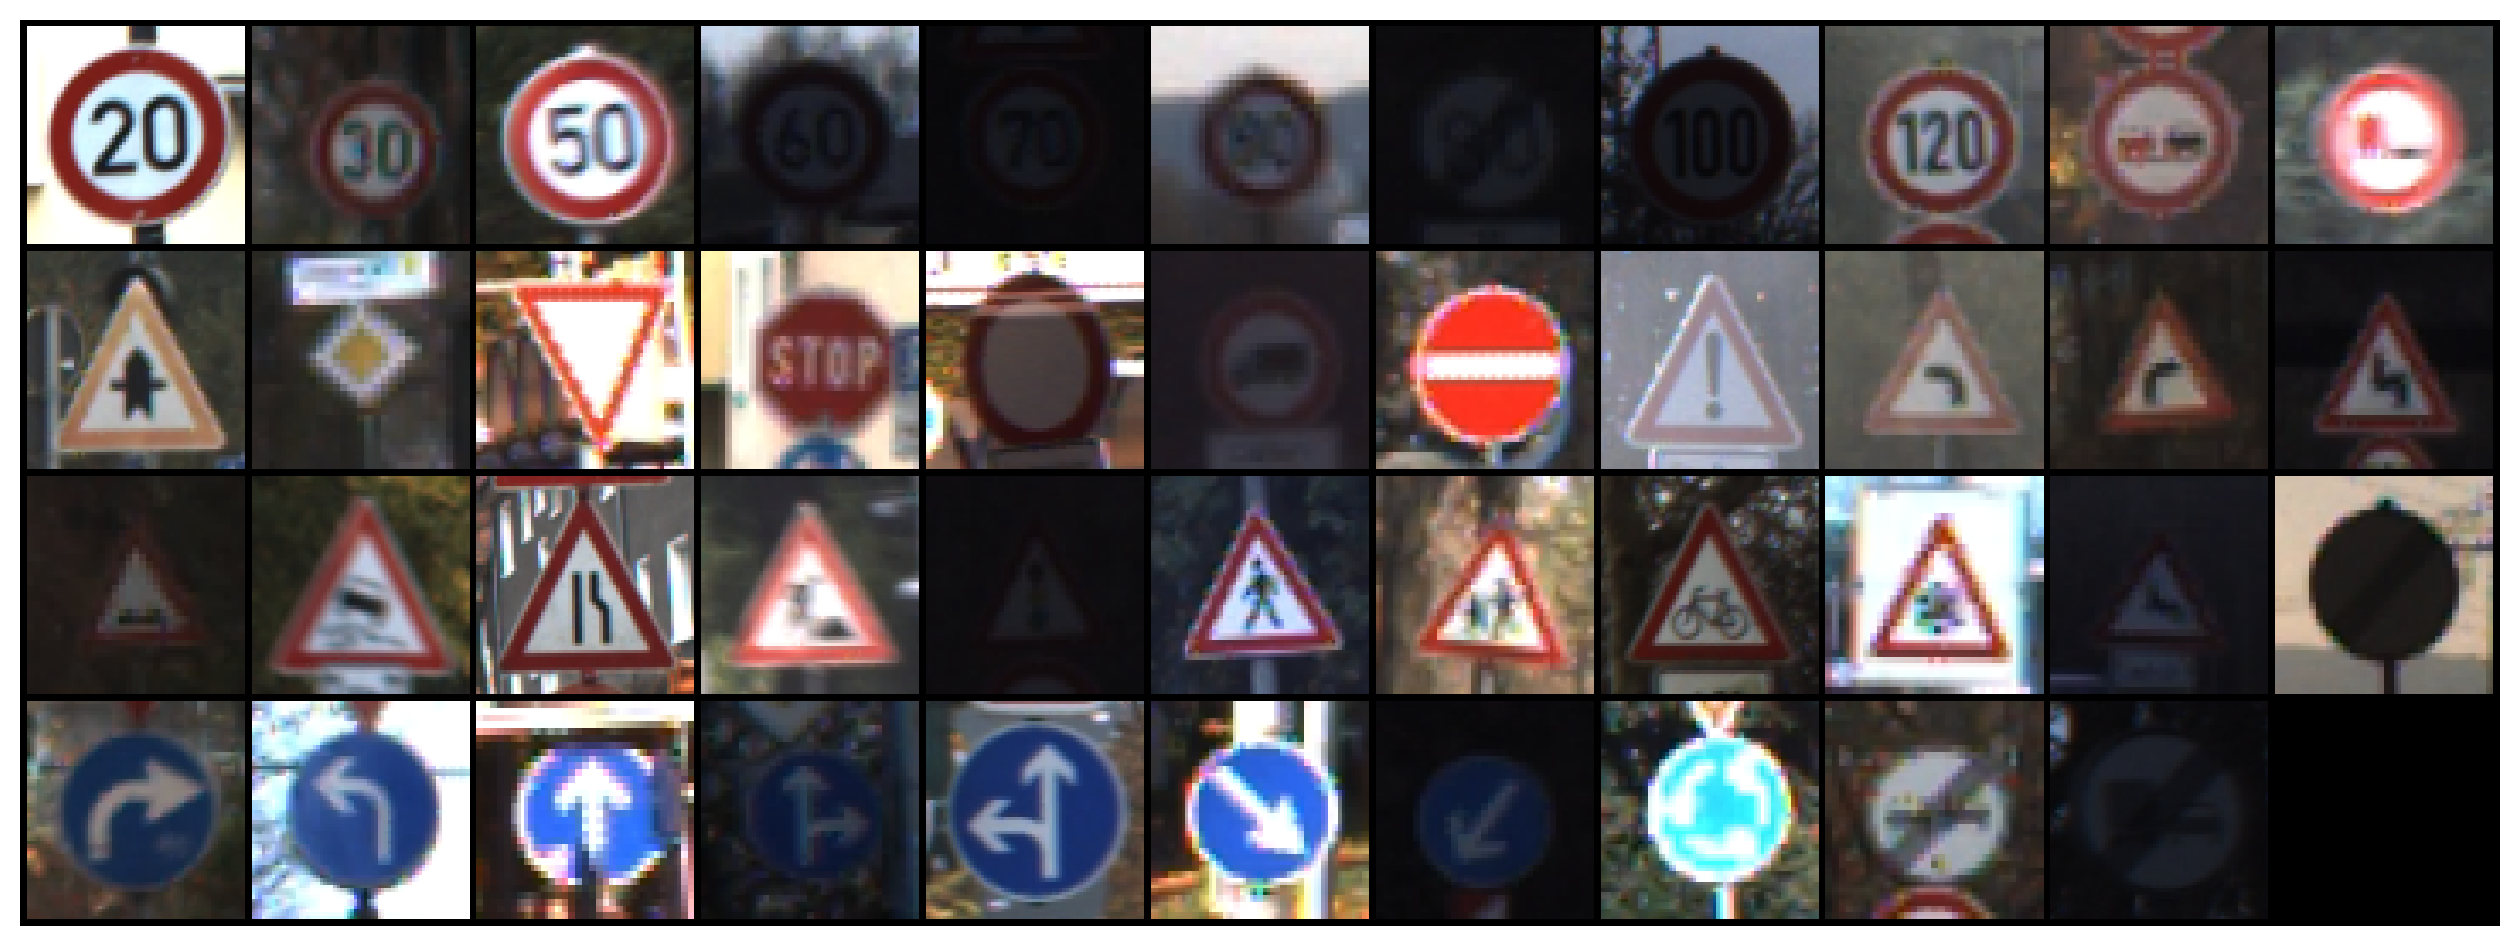

In [9]:
exemple_img=[]
for tf in train_folders:
  x=np.random.choice(glob(f'{tf}/*ppm'))
  exemple_img.append(x)
show_sign_grid(exemple_img)

#Building a dataset
**4 balanced class**


In [10]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]


**priority road**

(27, 27, 3)


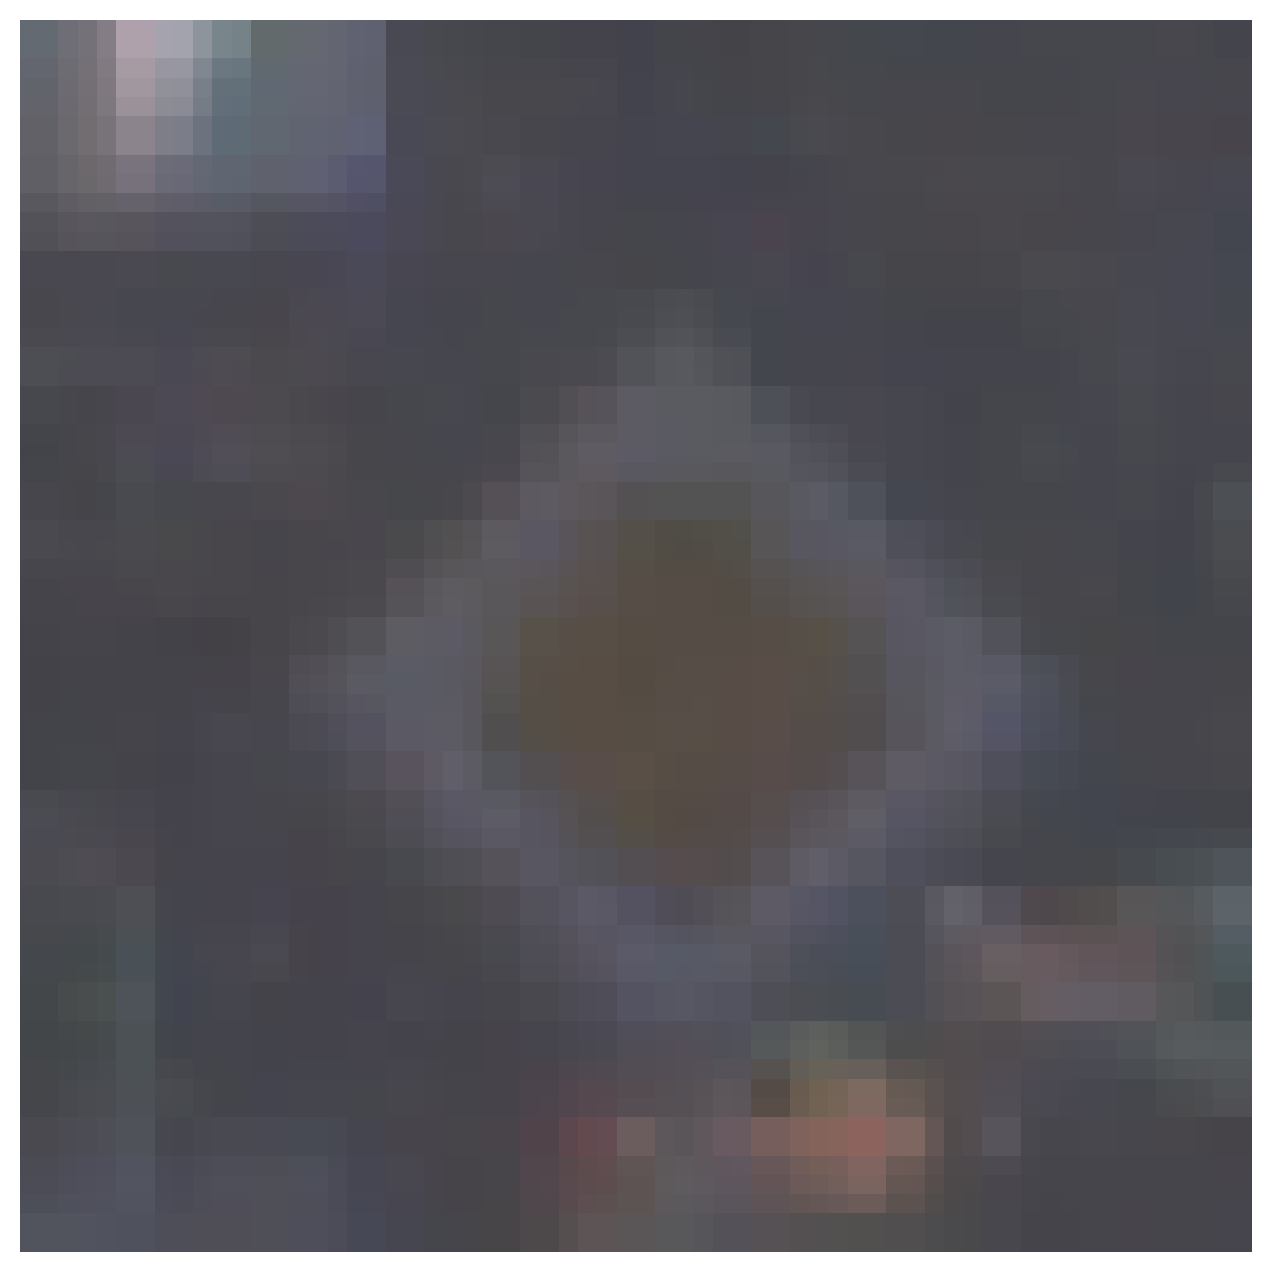

In [11]:
from PIL import Image
img_path = glob(f'{train_folders[12]}/*ppm')[31]

show_image(img_path)
img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

**give_way**

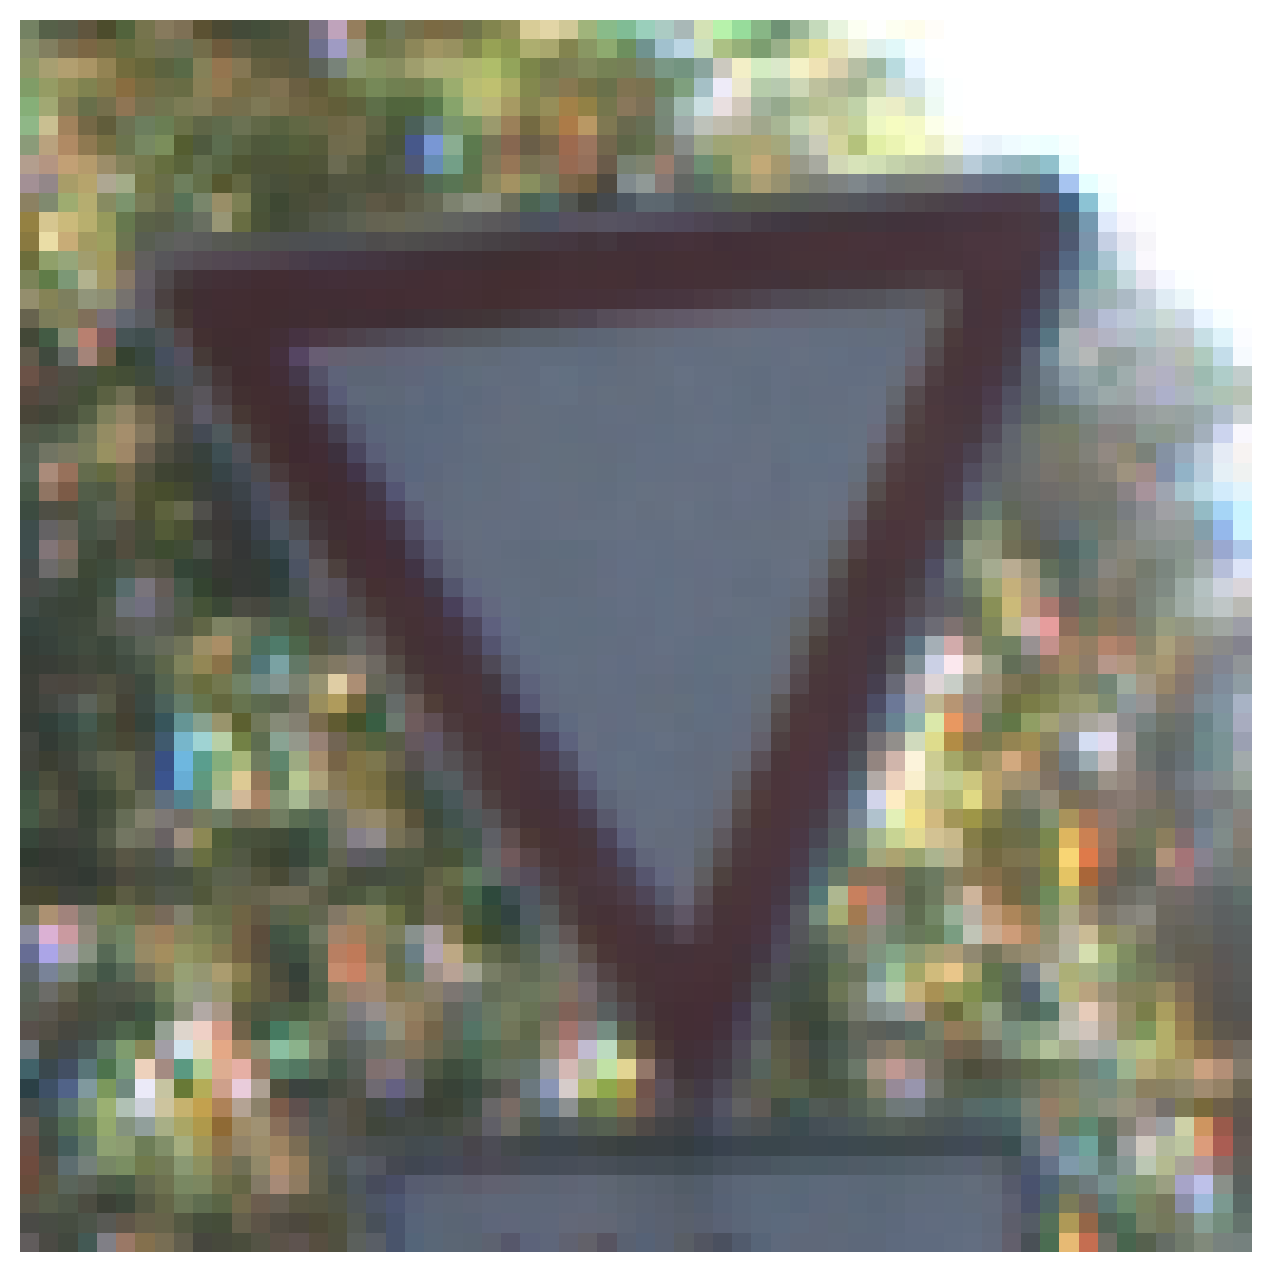

In [12]:
img_path = glob(f'{train_folders[13]}/*ppm')[13]

show_image(img_path)

**Stop**

(94, 93, 3)


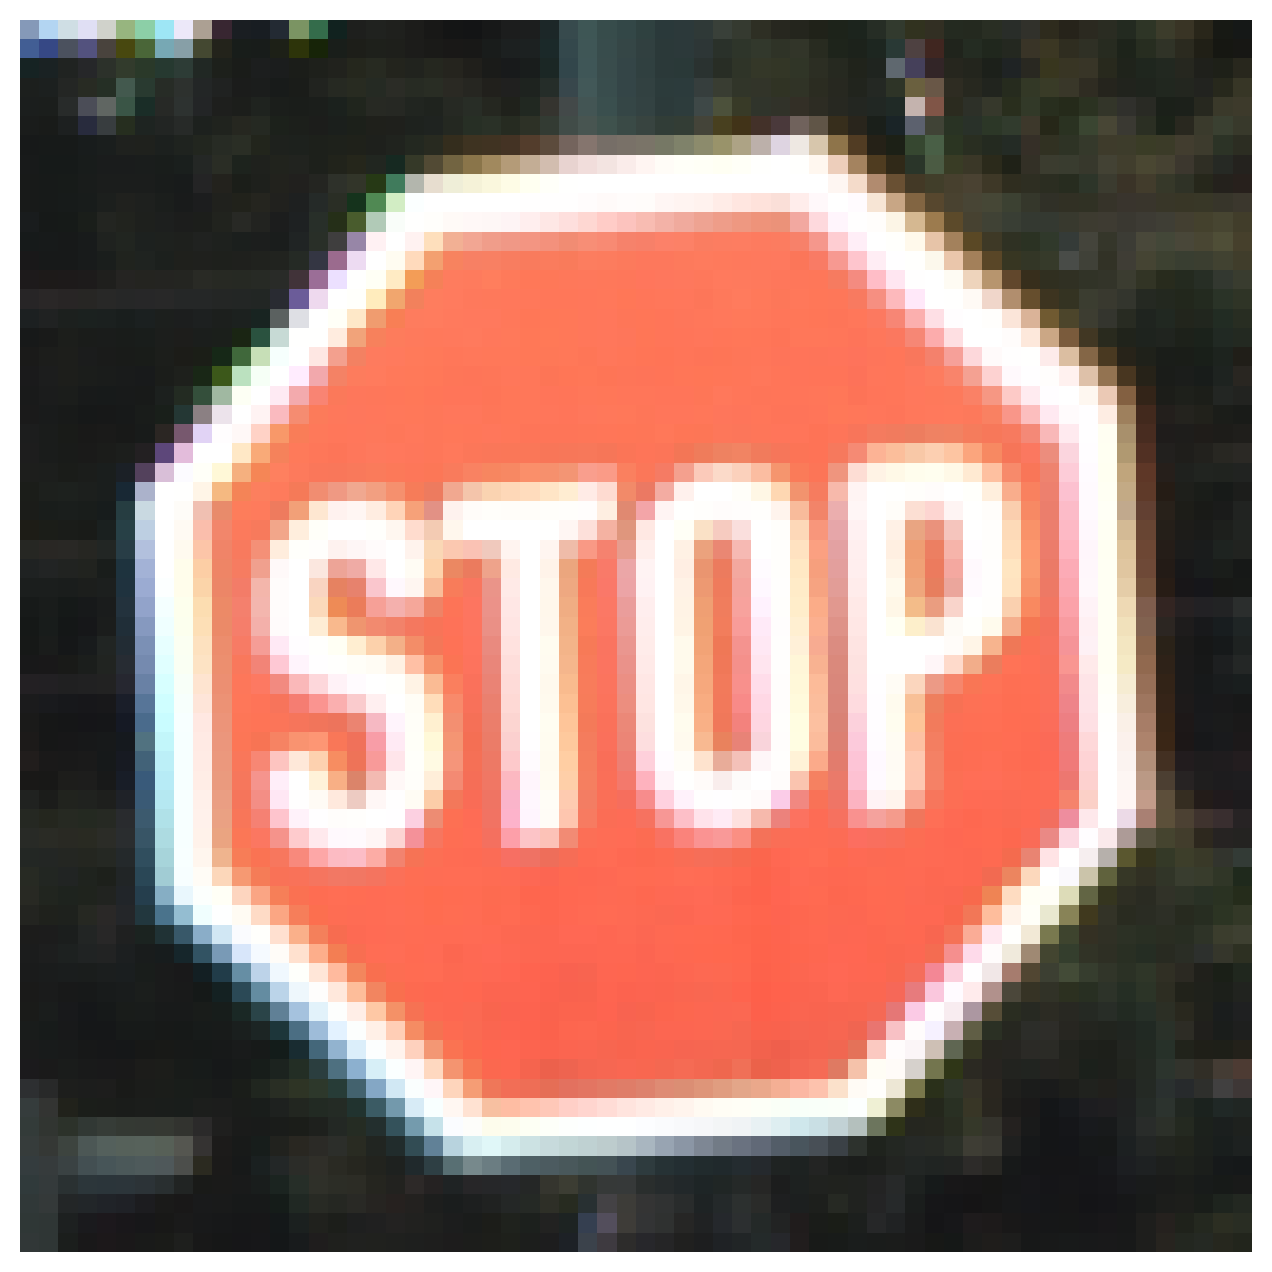

In [13]:
img_path = glob(f'{train_folders[14]}/*ppm')[3]

show_image(img_path)

img = cv2.imread(img_path)
dimensions = img.shape
print(dimensions)

**No entry**

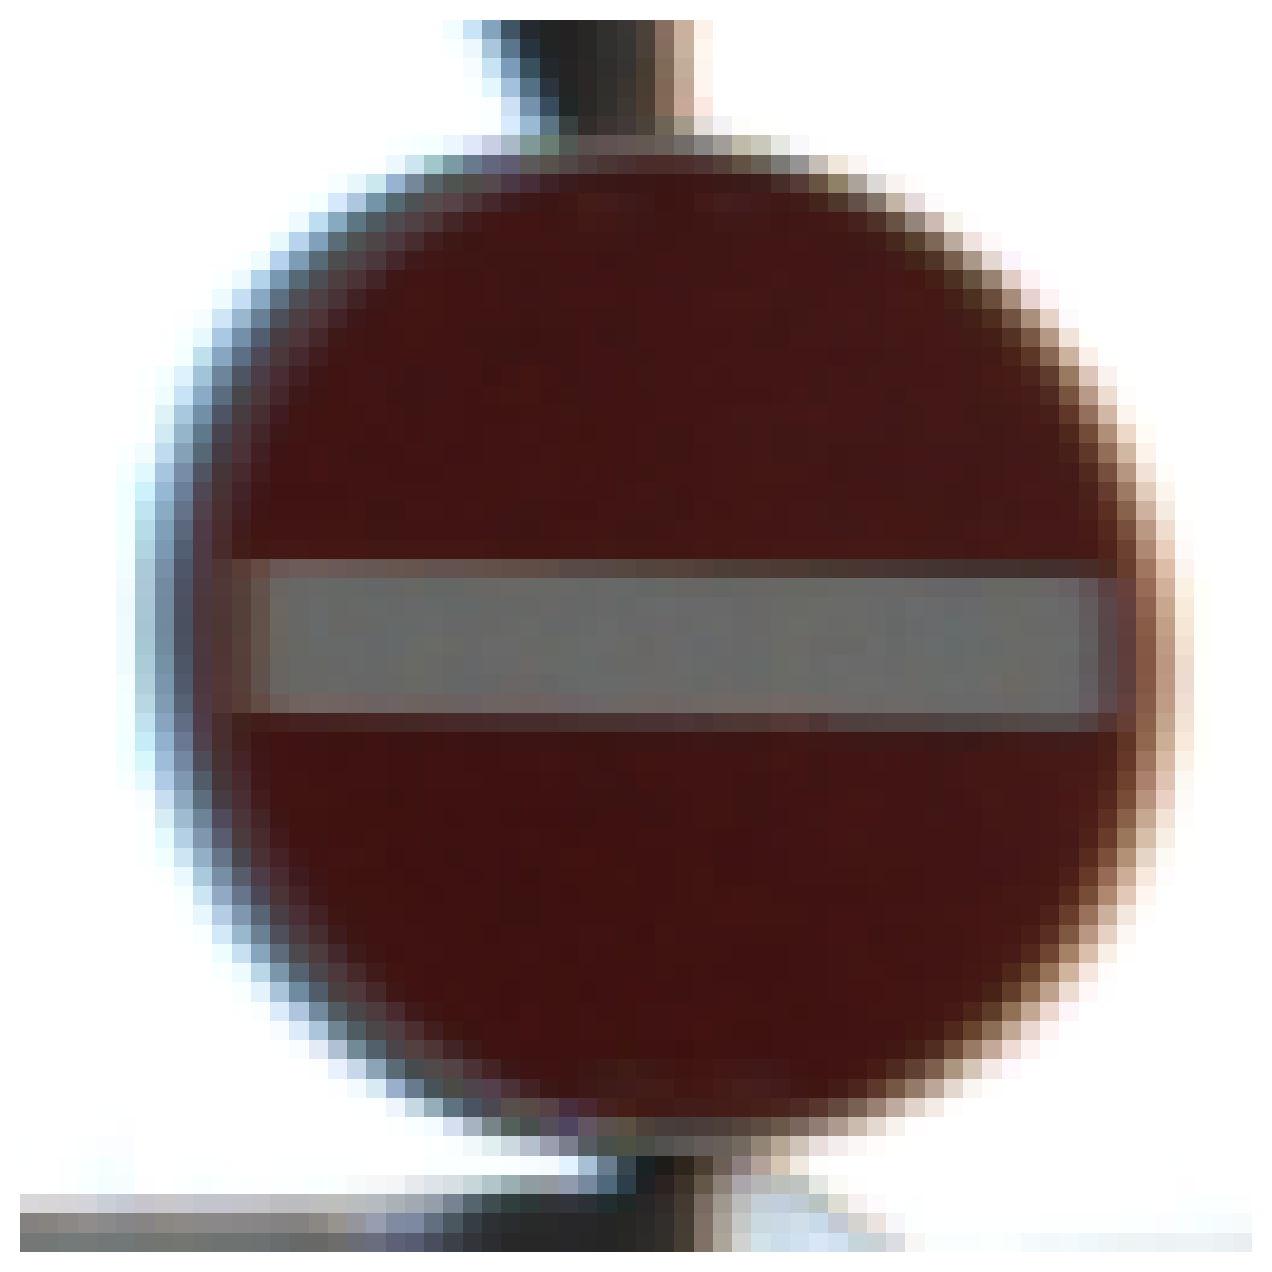

In [14]:
img_path = glob(f'{train_folders[17]}/*ppm')[62]

show_image(img_path)

In [15]:
!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)


for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


unbalanced dataset

In [16]:
for ds in DATASETS:
    for cls in class_names:
        image_paths = glob(f'{DATA_DIR}/{ds}/{cls}/*.ppm')
        num_images = len(image_paths)
        print(f'Dans le dossier {ds}, classe {cls} : {num_images} images.')

Dans le dossier train, classe priority_road : 1680 images.
Dans le dossier train, classe give_way : 1728 images.
Dans le dossier train, classe stop : 624 images.
Dans le dossier train, classe no_entry : 888 images.
Dans le dossier val, classe priority_road : 210 images.
Dans le dossier val, classe give_way : 216 images.
Dans le dossier val, classe stop : 78 images.
Dans le dossier val, classe no_entry : 111 images.
Dans le dossier test, classe priority_road : 210 images.
Dans le dossier test, classe give_way : 216 images.
Dans le dossier test, classe stop : 78 images.
Dans le dossier test, classe no_entry : 111 images.


split => 0.8 of the images for training, 0.1 for validation, and 0.1 test

#Data augmentation
**transformations**


In [17]:
def compute_mean_std(image_paths):

    mean_accumulator = np.zeros(3)
    std_accumulator = np.zeros(3)
    total_images = len(image_paths)

    for img_path in image_paths:

        img = Image.open(img_path)
        img = np.array(img) / 255.0

        mean_accumulator += np.mean(img, axis=(0, 1))
        std_accumulator += np.std(img, axis=(0, 1))

    mean_nums = mean_accumulator / total_images
    std_nums = std_accumulator / total_images

    return mean_nums, std_nums


mean_ds_split, std_ds_split = compute_mean_std(ds_split[0])

print("Moyenne pour l'ensemble d'entraînement (ds_split) :", mean_ds_split)
print("Écart-type pour l'ensemble d'entraînement (ds_split) :", std_ds_split)


Moyenne pour l'ensemble d'entraînement (ds_split) : [0.35182217 0.2811871  0.28272362]
Écart-type pour l'ensemble d'entraînement (ds_split) : [0.17814601 0.17033    0.17866557]


In [23]:
mean_nums = [0.35724255, 0.28496815, 0.28595125]
std_nums = [0.1803585,  0.17152867, 0.18031636]
from torchvision import transforms
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])
, 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}


#Build datasets
DataLoader PyTorch (Normalisation +tensors)

In [19]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import uuid
import shutil
import os

# transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
])


In [20]:
import random


underrepresented_classes = ['priority_road',  'no_entry','give_way', 'stop']


AUGMENTED_DATA_DIR = Path('augmented_data')
AUGMENTED_DATA_DIR.mkdir(parents=True, exist_ok=True)


num_augmented_images = 500


for cls in underrepresented_classes:
    class_dir = DATA_DIR / 'train' / cls
    images = list(class_dir.glob('*.ppm'))


    random.shuffle(images)
    selected_images = images[:num_augmented_images]


    augmented_class_dir = AUGMENTED_DATA_DIR / 'train' / cls
    augmented_class_dir.mkdir(parents=True, exist_ok=True)


    for img_path in selected_images:
        original_image = Image.open(img_path)
        augmented_image = train_transforms(original_image)

        augmented_image_pil = transforms.ToPILImage()(augmented_image)

        new_image_path = augmented_class_dir / (str(uuid.uuid4()) + '.ppm')
        augmented_image_pil.save(new_image_path)

    # Mélanger les images dans le répertoire augmenté
    augmented_images = list(augmented_class_dir.glob('*.ppm'))
    random.shuffle(augmented_images)
    for i, image_path in enumerate(augmented_images):
        new_image_path = augmented_class_dir / f'{i:04d}.ppm'
        image_path.rename(new_image_path)



Classe : priority_road, Nombre d'images augmentées : 500


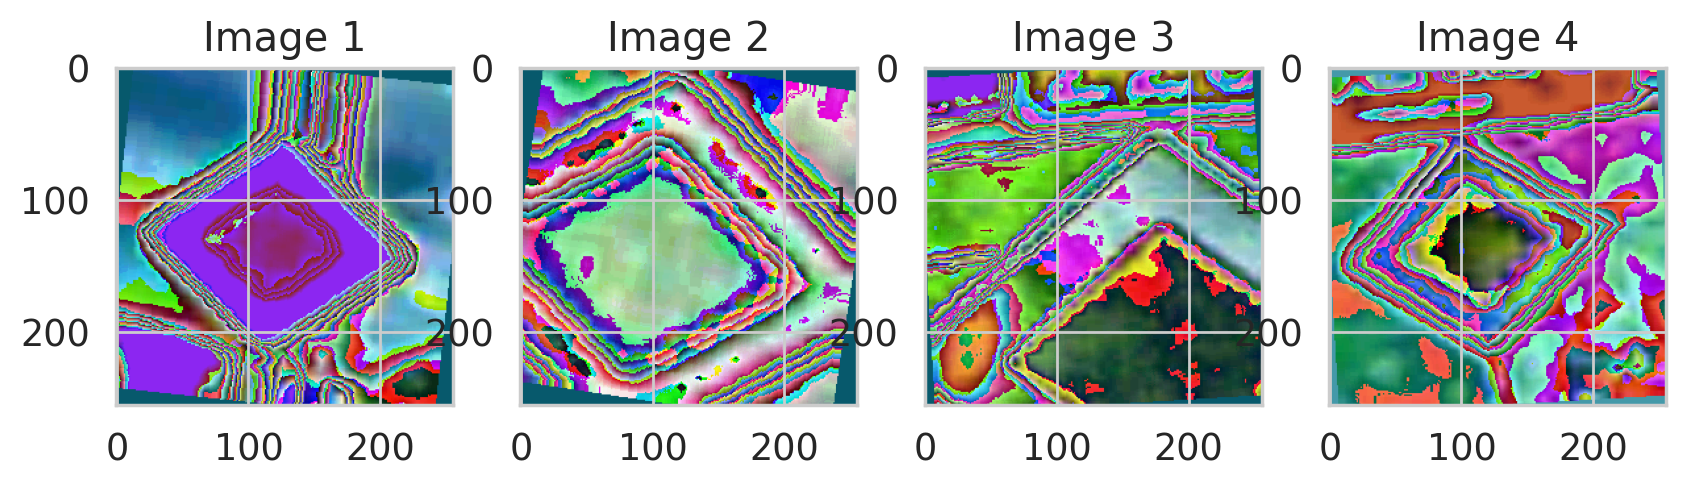

Classe : no_entry, Nombre d'images augmentées : 500


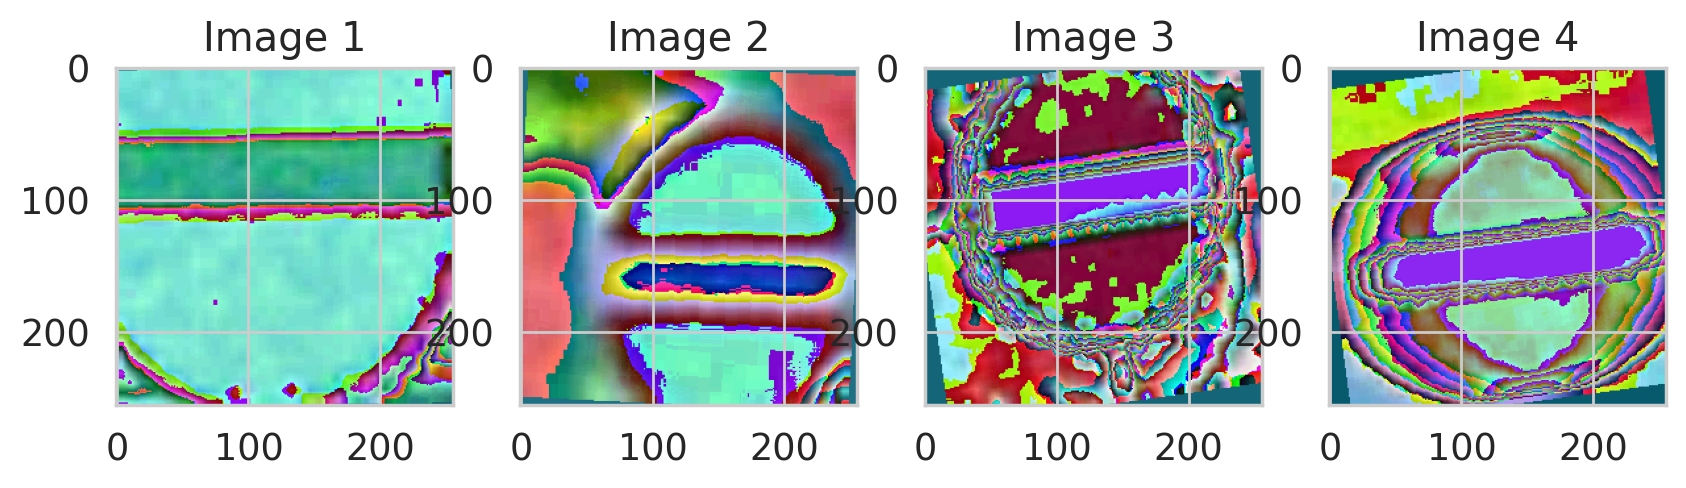

Classe : give_way, Nombre d'images augmentées : 500


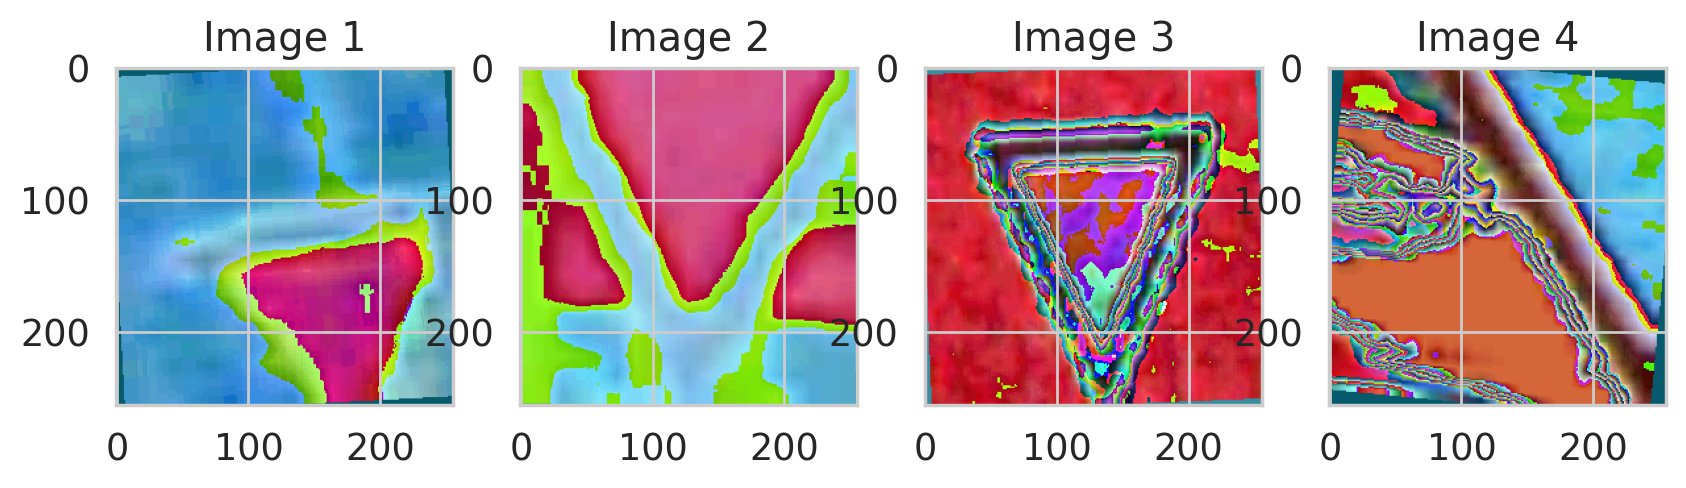

Classe : stop, Nombre d'images augmentées : 500


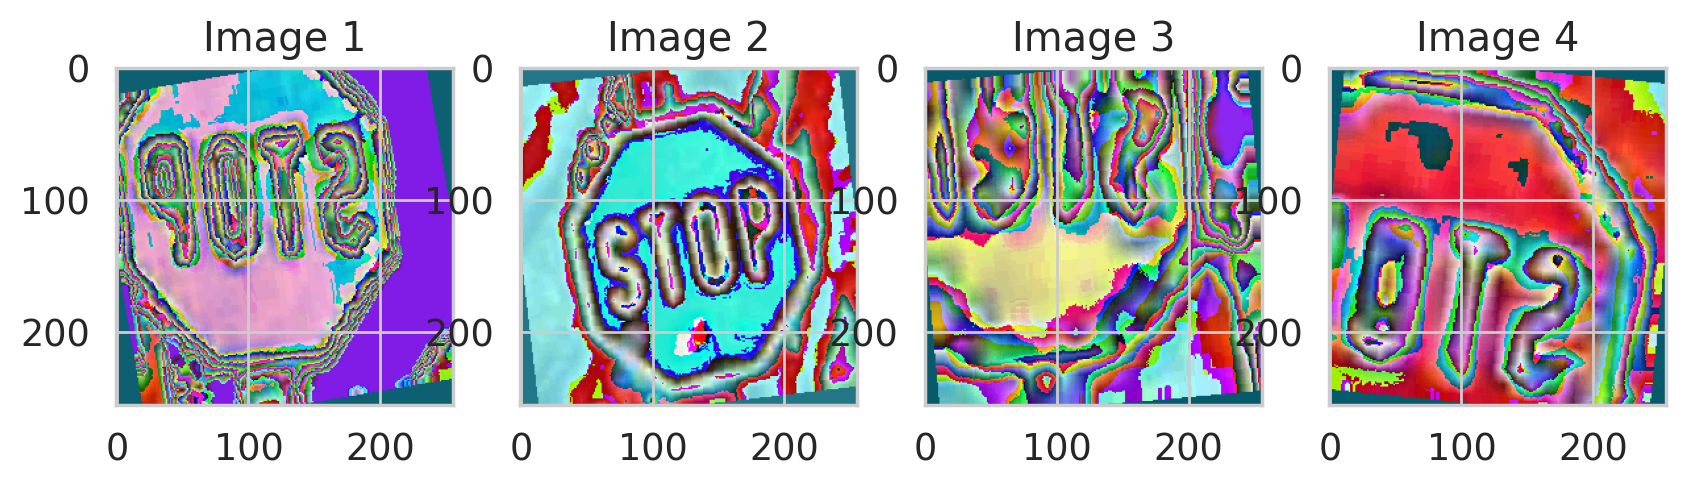

Classe : priority_road, Nombre total d'images augmentées : 500
Classe : no_entry, Nombre total d'images augmentées : 500
Classe : give_way, Nombre total d'images augmentées : 500
Classe : stop, Nombre total d'images augmentées : 500


In [21]:
import matplotlib.pyplot as plt

# Classes à examiner
classes_to_check = ['priority_road', 'no_entry', 'give_way', 'stop']


augmented_images_count = {}

for cls in classes_to_check:
    augmented_class_dir = AUGMENTED_DATA_DIR / 'train' / cls
    augmented_images = list(augmented_class_dir.glob('*.ppm'))

    # Compter le nombre d'images augmentées pour cette classe
    count = len(augmented_images)
    augmented_images_count[cls] = count

    # Afficher les images augmentées
    if count > 0:
        print(f"Classe : {cls}, Nombre d'images augmentées : {count}")
        plt.figure(figsize=(10, 10))
        for i in range(min(4, count)):
            image_path = augmented_images[i]
            img = Image.open(image_path)
            plt.subplot(1, 4, i+1)
            plt.imshow(img)
            plt.title(f"Image {i+1}")
        plt.show()

# Afficher le nombre total d'images augmentées pour chaque classe
for cls, count in augmented_images_count.items():
    print(f"Classe : {cls}, Nombre total d'images augmentées : {count}")


In [24]:
image_datasets = {}
data_loaders = {}

for d in DATASETS:
    chemin_dataset = f'{DATA_DIR}/{d}'
    image_datasets[d] = ImageFolder(chemin_dataset, transforms[d])
    data_loaders[d] = DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=1)
    print(f"Taille  {d}: {len(data_loaders[d].dataset)} images")



Taille  train: 4920 images
Taille  val: 615 images
Taille  test: 615 images


In [25]:
images_count_par_classe_par_ensemble = {'train': {}, 'val': {}, 'test': {}}

# Parcourez les ensembles (train, val, test)
for d in DATASETS:
    ensemble = image_datasets[d]


    for classe, idx in ensemble.class_to_idx.items():

        nb_images_classe = len(ensemble.targets) - ensemble.targets.count(idx)
        images_count_par_classe_par_ensemble[d][classe] = nb_images_classe

# Affichez le nombre d'images par classe et par ensemble
for ensemble, classes in images_count_par_classe_par_ensemble.items():
    print(f"Ensemble : {ensemble}")
    for classe, count in classes.items():
        print(f"Classe : {classe}, Nombre d'images : {count}")

Ensemble : train
Classe : give_way, Nombre d'images : 3192
Classe : no_entry, Nombre d'images : 4032
Classe : priority_road, Nombre d'images : 3240
Classe : stop, Nombre d'images : 4296
Ensemble : val
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537
Ensemble : test
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537


In [26]:
from torchvision.datasets import ImageFolder


augmented_priority_road_dir = Path('/content/augmented_data/train/priority_road')
augmented_give_way_dir = Path('/content/augmented_data/train/give_way')


image_datasets['train'].class_to_idx.update({'priority_road': len(image_datasets['train'].classes) - 1, 'give_way': len(image_datasets['train'].classes) - 1})
image_datasets['train'].samples += [(path, len(image_datasets['train'].classes) - 1) for path in augmented_priority_road_dir.glob('*.ppm')]
image_datasets['train'].samples += [(path, len(image_datasets['train'].classes) - 1) for path in augmented_give_way_dir.glob('*.ppm')]


data_loaders['train'] = DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=1)





In [27]:
for d in DATASETS:
    ensemble = image_datasets[d]

    # Parcourez chaque classe
    for classe, idx in ensemble.class_to_idx.items():
        # Comptez le nombre d'images pour cette classe dans cet ensemble
        nb_images_classe = len(ensemble.targets) - ensemble.targets.count(idx)
        images_count_par_classe_par_ensemble[d][classe] = nb_images_classe

# Affichez le nombre d'images par classe et par ensemble
for ensemble, classes in images_count_par_classe_par_ensemble.items():
    print(f"Ensemble : {ensemble}")
    for classe, count in classes.items():
        print(f"Classe : {classe}, Nombre d'images : {count}")

Ensemble : train
Classe : give_way, Nombre d'images : 4296
Classe : no_entry, Nombre d'images : 4032
Classe : priority_road, Nombre d'images : 4296
Classe : stop, Nombre d'images : 4296
Ensemble : val
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537
Ensemble : test
Classe : give_way, Nombre d'images : 399
Classe : no_entry, Nombre d'images : 504
Classe : priority_road, Nombre d'images : 405
Classe : stop, Nombre d'images : 537


num_workers=nb processus (max=2)

In [28]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
print(dataset_sizes)




{'train': 5920, 'val': 615, 'test': 615}


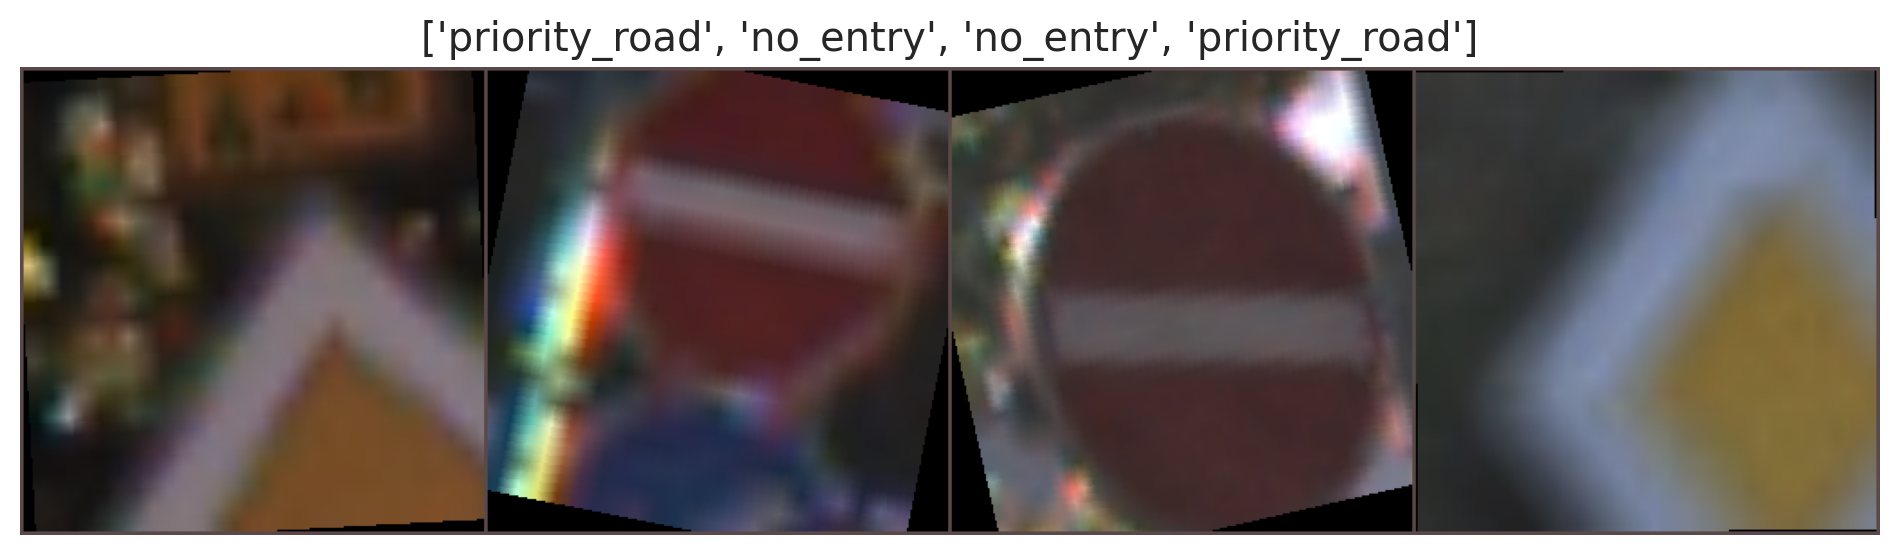

In [69]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


##Using a pre-trained model
 1- **Transfer Learning** from **ResNet101** model

In [52]:
from torchvision.models import resnet101
from torchvision.models import resnet34
import torchvision.models as models
from torchvision.models import ResNet101_Weights


def create_model(n_classes):

    model = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = False

    model.fc.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, n_classes)
    '''model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(512, n_classes),
        nn.Softmax(dim=1)
    )'''

    return model.to(device)




 instance of the model:

In [55]:
base_model = create_model(len(class_names))

In [54]:
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Training


In [56]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history


In [59]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.6801160785929627 accuracy 0.7400337837837838
Val   loss 0.27507081348751367 accuracy 0.9040650406504065

Epoch 2/10
----------
Train loss 0.5164796945928419 accuracy 0.8082770270270271
Val   loss 0.20714800372151296 accuracy 0.9170731707317074

Epoch 3/10
----------
Train loss 0.5010673848109798 accuracy 0.8170608108108108
Val   loss 0.1165008385931807 accuracy 0.967479674796748

Epoch 4/10
----------
Train loss 0.4680508017848321 accuracy 0.8234797297297298
Val   loss 0.17103085853235023 accuracy 0.9365853658536585

Epoch 5/10
----------
Train loss 0.46885883937026623 accuracy 0.8309121621621622
Val   loss 0.2912419503299571 accuracy 0.8845528455284553

Epoch 6/10
----------
Train loss 0.4565038581341788 accuracy 0.831418918918919
Val   loss 0.18552291080102026 accuracy 0.9252032520325203

Epoch 7/10
----------
Train loss 0.4331201617952477 accuracy 0.843918918918919
Val   loss 0.09253610499883932 accuracy 0.9772357723577236

Epoch 8/10
----------
Tr

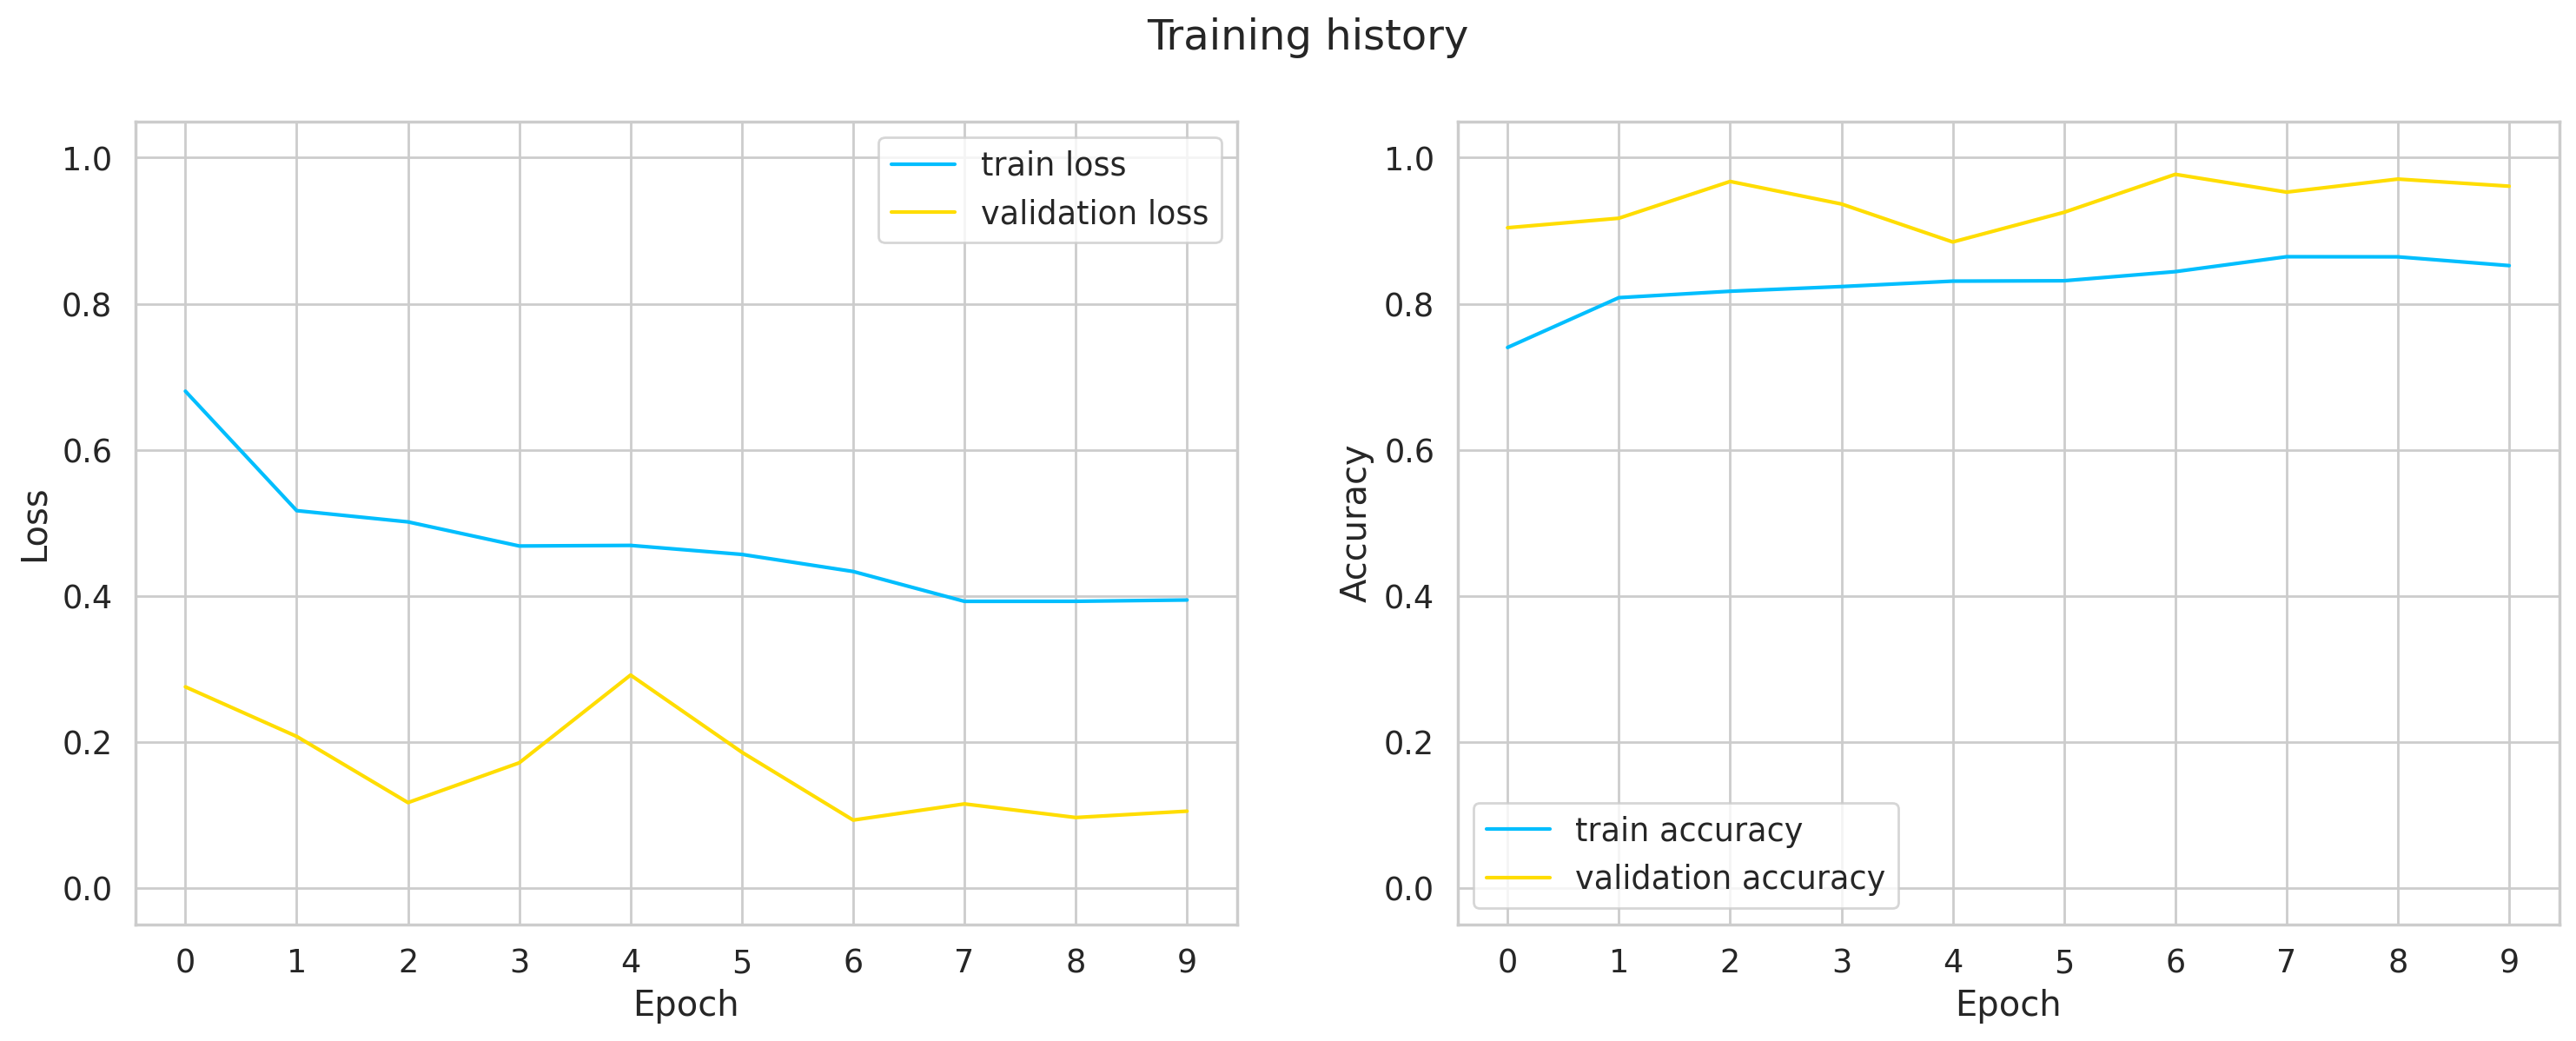

In [60]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  train_loss = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['train_loss']]
  val_loss = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['val_loss']]
  train_acc = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['train_acc']]
  val_acc = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in history['val_acc']]

  ax1.plot(train_loss, label='train loss')
  ax1.plot(val_loss, label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(train_acc, label='train accuracy')
  ax2.plot(val_acc, label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

plot_training_history(history)



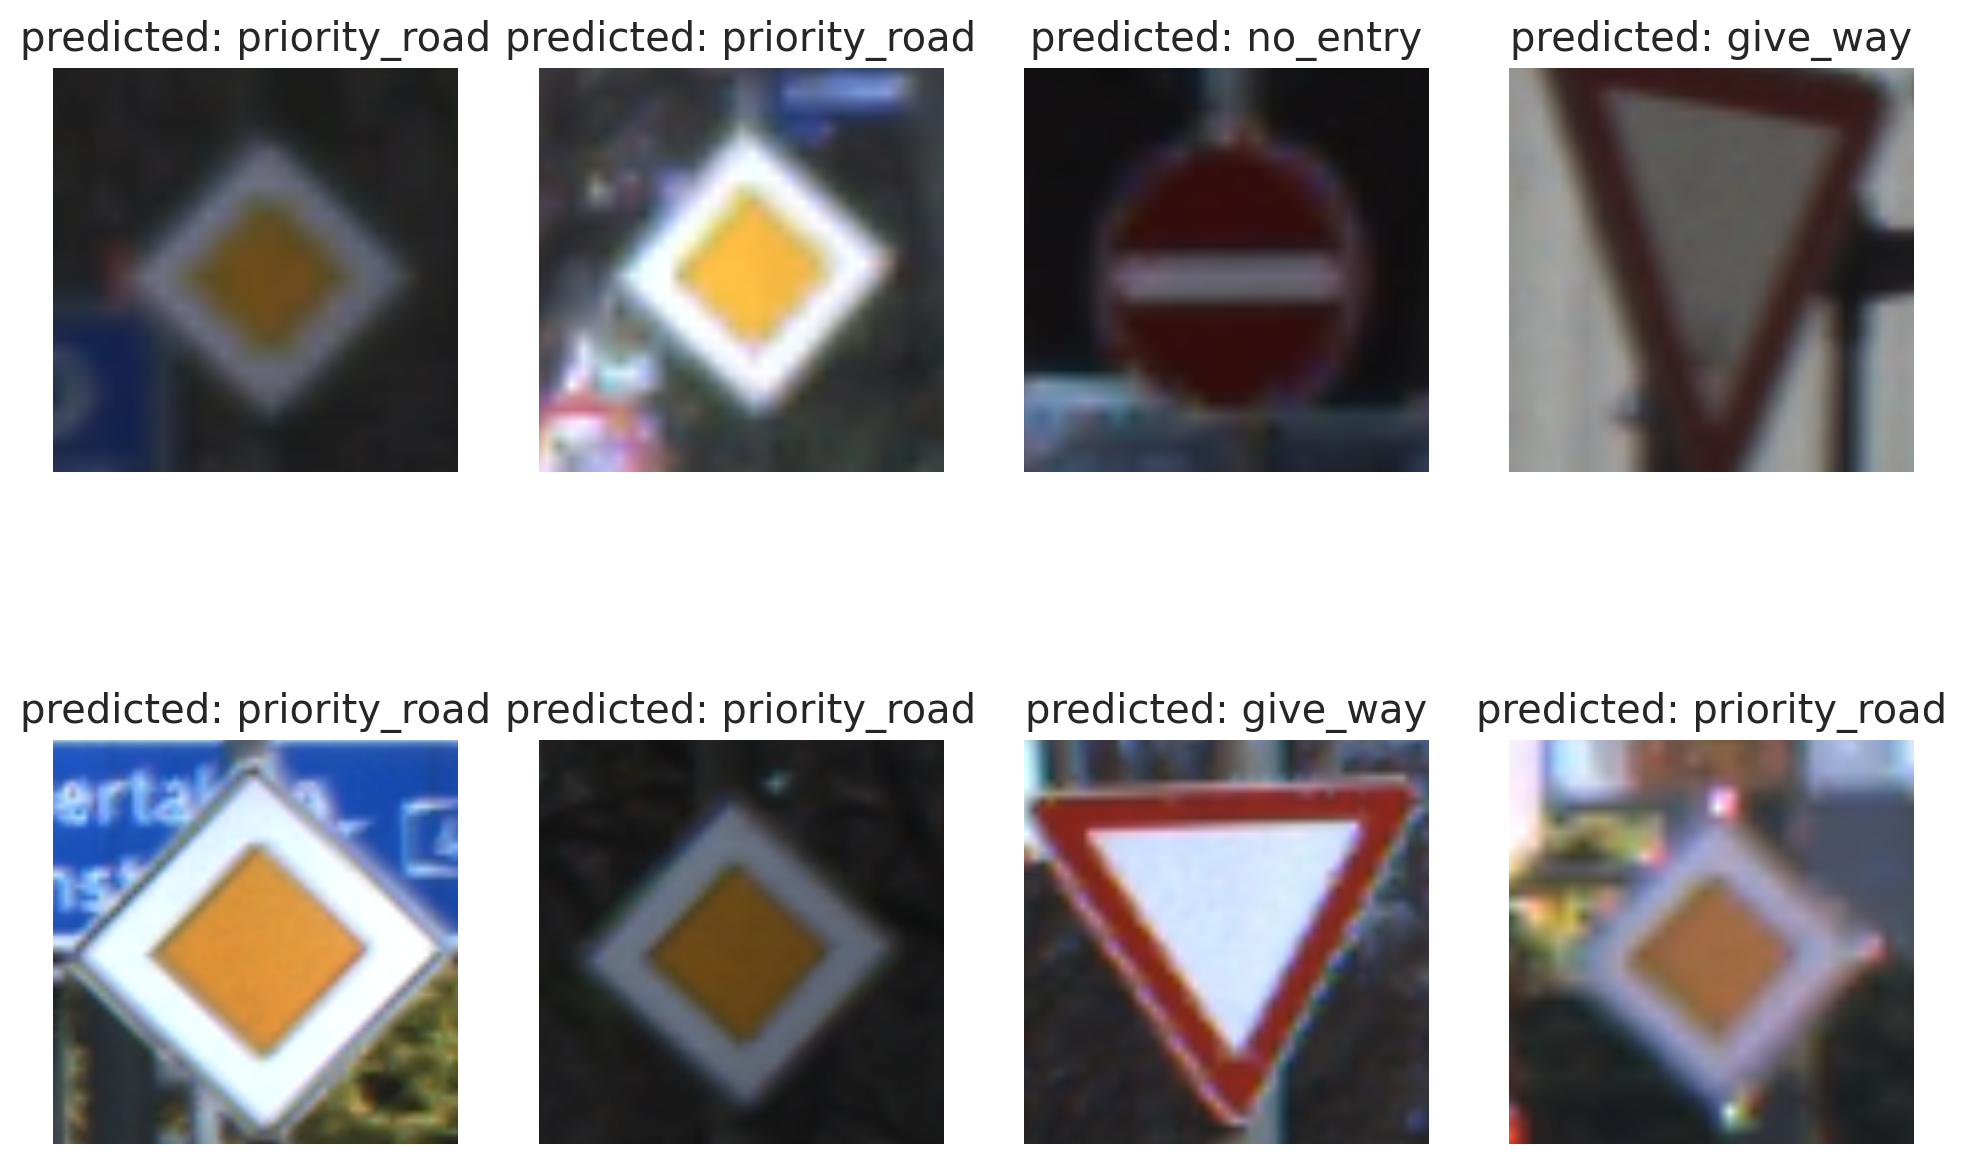

In [61]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return
show_predictions(base_model, class_names, n_images=8)

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       0.99      0.94      0.96       216
     no_entry       0.97      0.99      0.98       111
priority_road       0.96      0.99      0.97       210
         stop       0.97      1.00      0.99        78

     accuracy                           0.97       615
    macro avg       0.97      0.98      0.98       615
 weighted avg       0.97      0.97      0.97       615



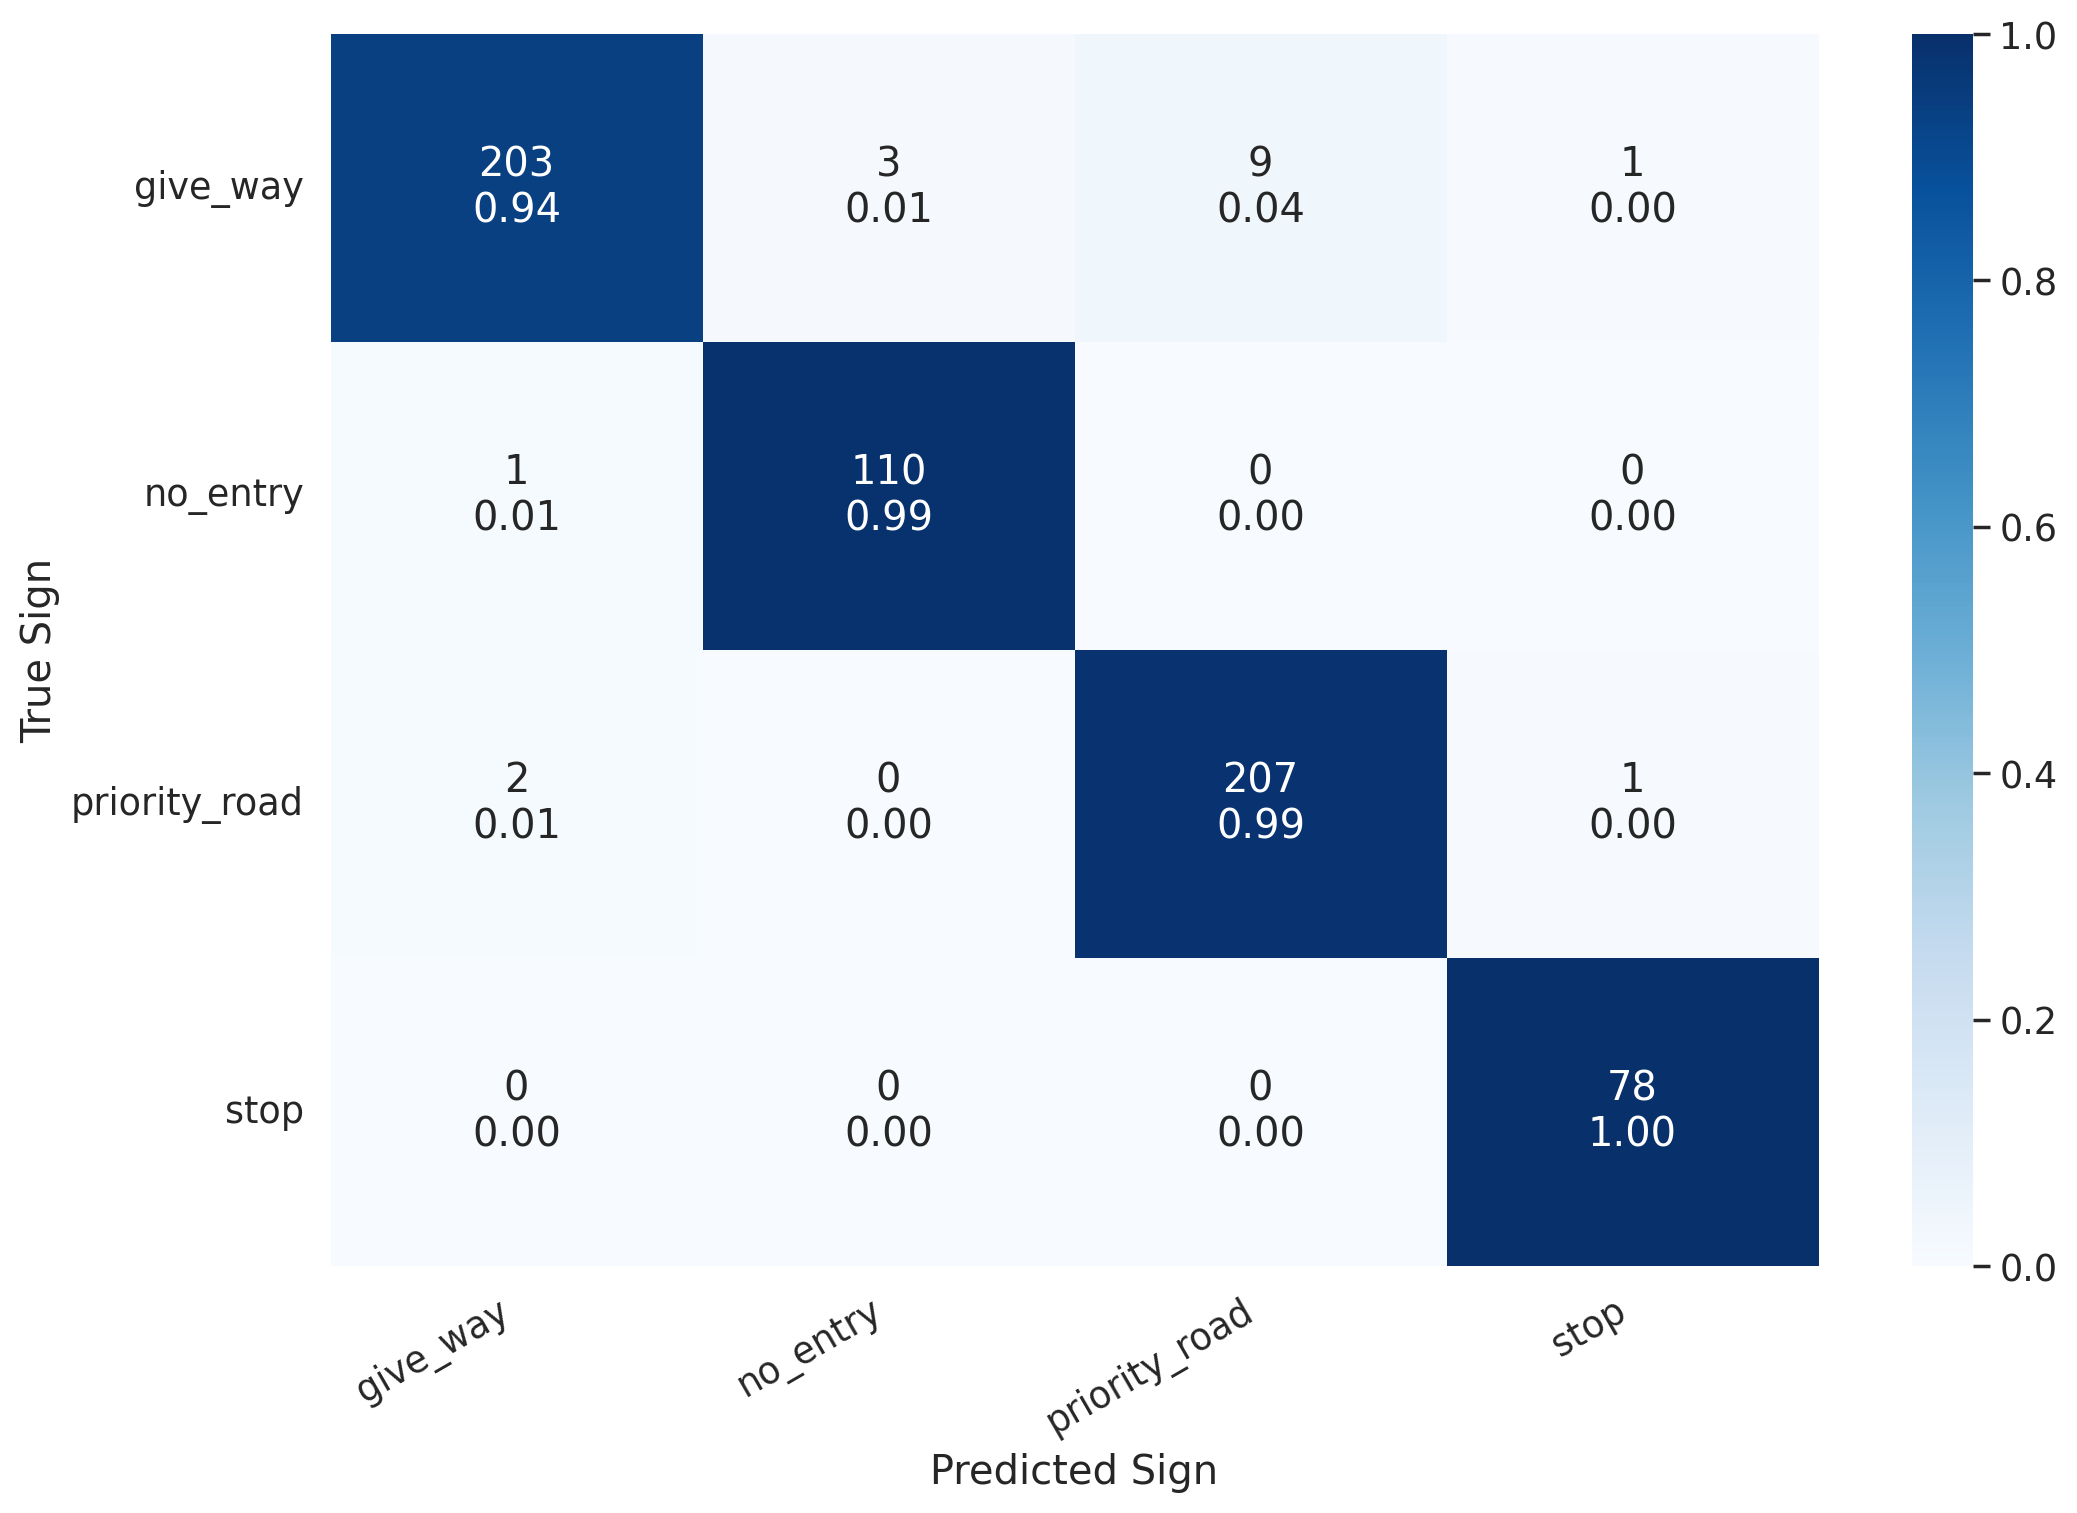

In [63]:
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

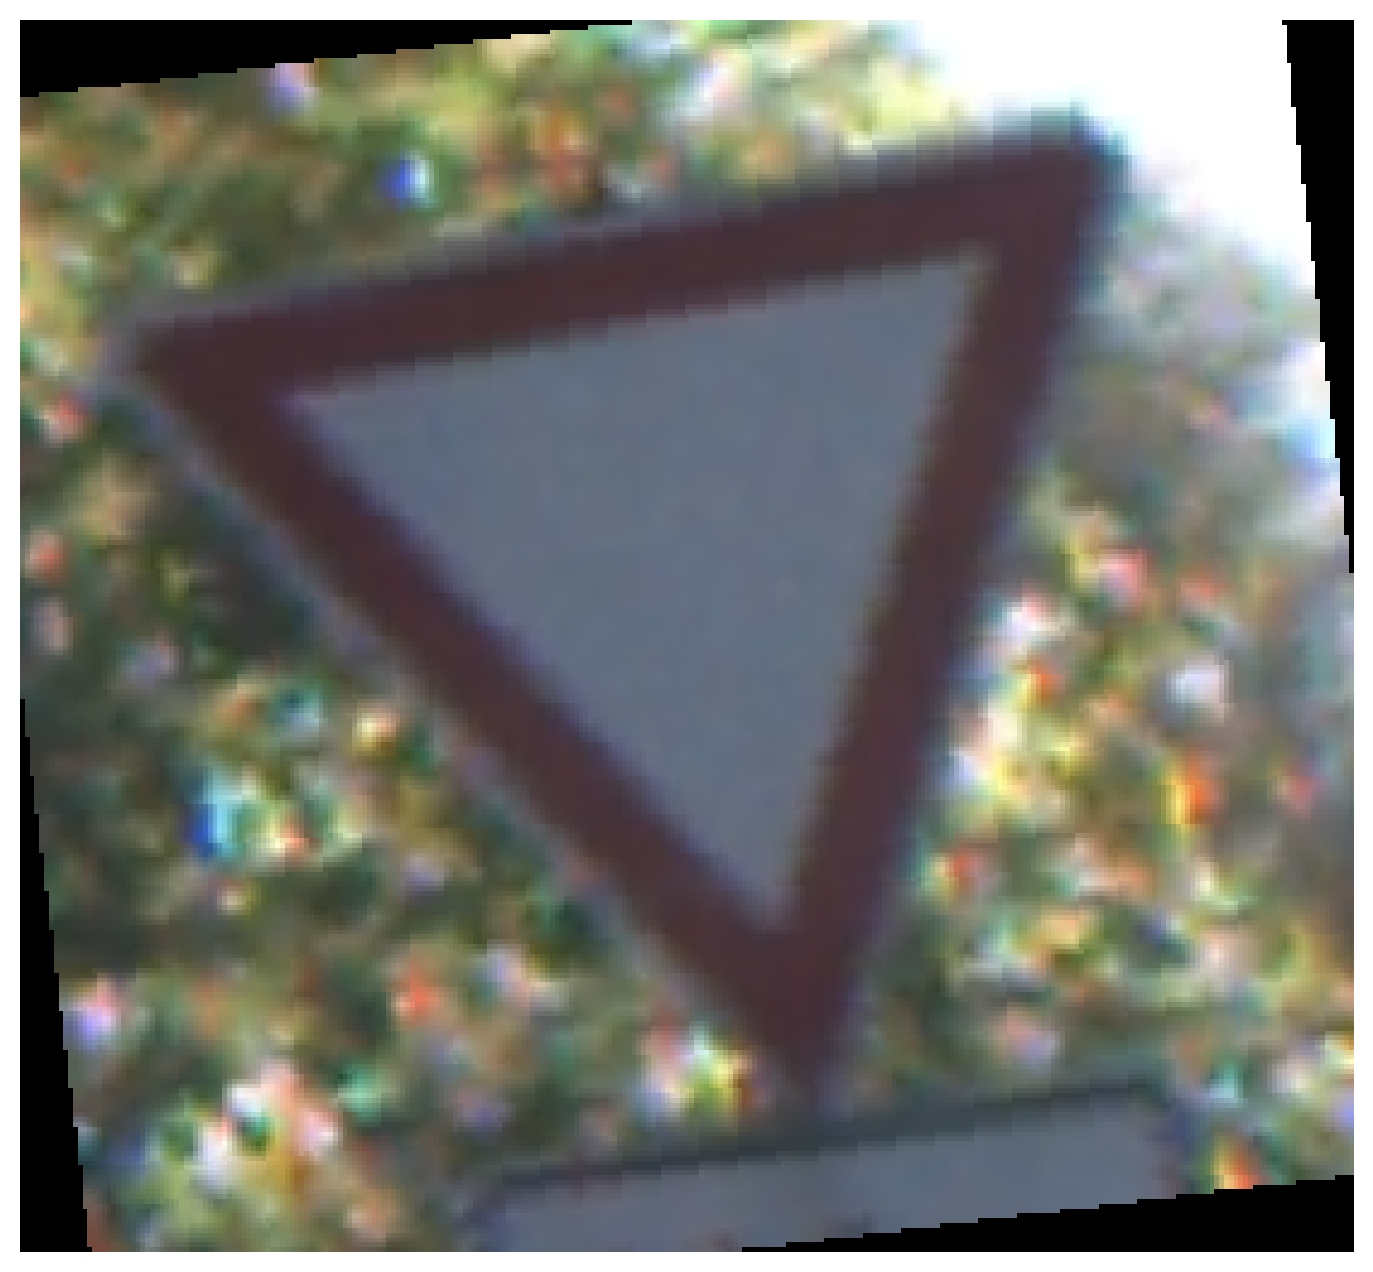

In [64]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
img_path = glob(f'{train_folders[13]}/*ppm')[13]
image = Image.open(img_path)
show_image(img_path)
transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(degrees=30)
])

transformed_image = transforms_test(image)


plt.imshow(transformed_image)
plt.show()

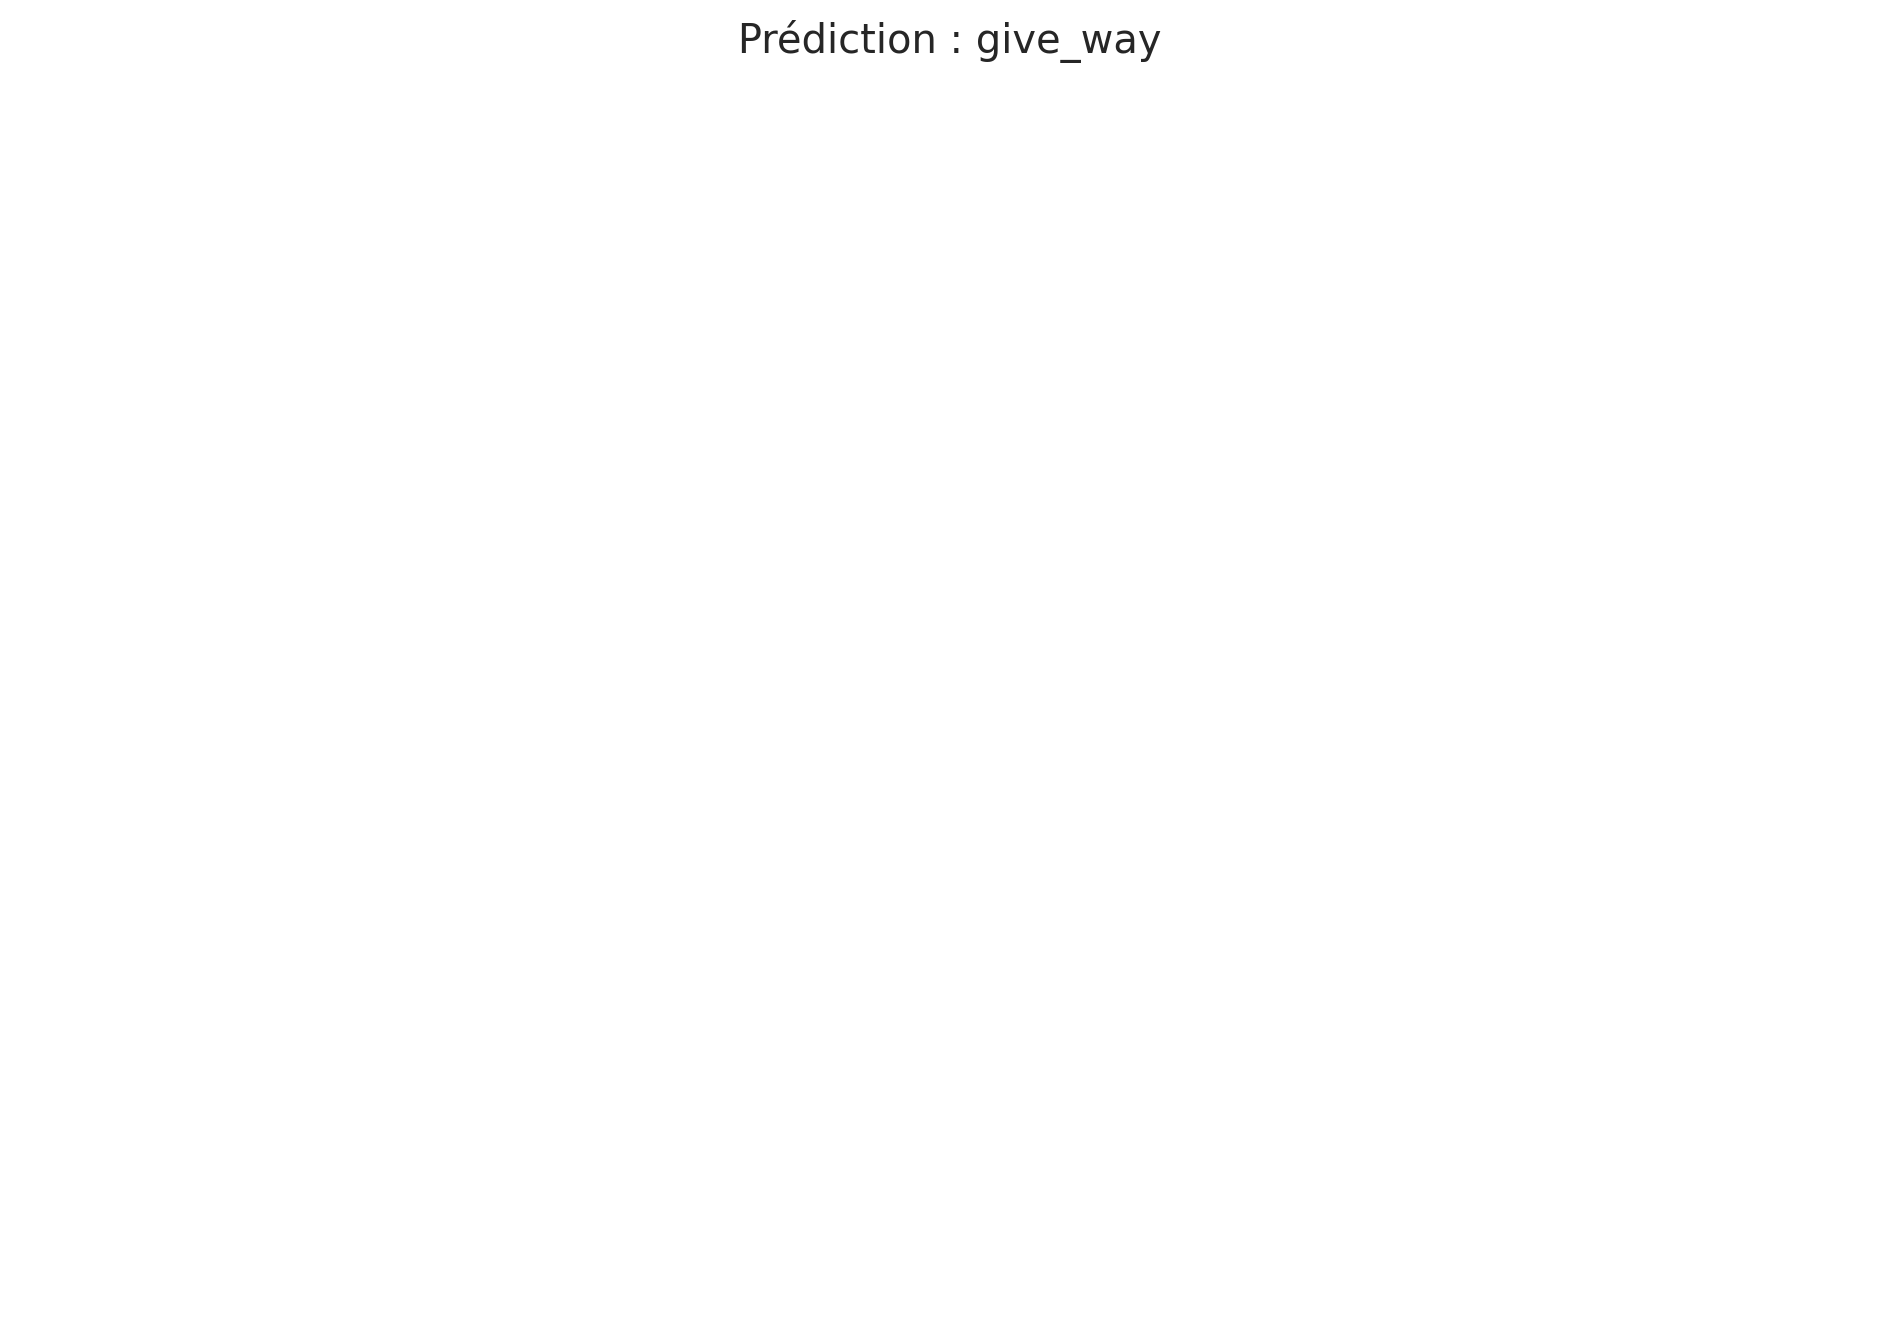

In [65]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def pil_to_tensor(image):
    image = np.array(image)
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    return image.unsqueeze(0)

def show_single_image_prediction(model, transformed_image, class_names, device):
    model = model.eval()

    transformed_image = pil_to_tensor(transformed_image).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        _, preds = torch.max(output, 1)

    plt.figure()
    ax = plt.gca()
    ax.set_title(f'Prédiction : {class_names[preds[0].item()]}')

    ax.axis('off')
    plt.show()


show_single_image_prediction(base_model, transformed_image, class_names, device)


